First, we'll look at how to train a linear regression model.

In [1]:
# Let's produce a randomly generated linear dataset

import numpy as np

# Generate 100 x values from 0 to 2
X = 2 * np.random.rand(100, 1)
# Generate 100 y values around the line 4 + 3*x, with some normally distributed noise
y = 4 + 3 * X + np.random.randn(100, 1)

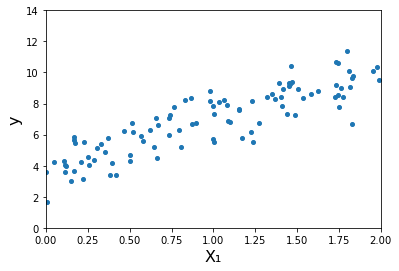

In [2]:
# Let's plot the data

import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.scatter(X, y, s=16)
plt.axis([0,2,0,14])
plt.show()

For linear regression models, we typically use an MSE(Mean Squared Error) cost function, which we want to minimize. 

There is a closed-form solution for the vector theta that does so, where y_pred = theta_0 + theta_1*x is our estimate for the line.

The formula is:

theta = (X^T*X)^(-1) * X^T * y, 

where y is the vector containing all y values in our training set, and where X = (x_1, ..., x_n) contains row vectors x_i^T = (1, x).

In [3]:
# We glue a row of ones to the top of our X matrix, before computing the cost-minimizing vector theta

X_b = np.c_[np.ones((100, 1)), X]

theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

theta_best

array([[3.8324178 ],
       [3.16940179]])

Our model predicts the line 4 + 2.98*x, which is... shockingly close to the values we would have hoped for.

In [4]:
# Now, given the x value of a new data point, we can make a prediction for the corresponding y-value, using our model

X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.8324178 ],
       [10.17122139]])

Our model predicts the points (0, 4) and (2, 9.95).

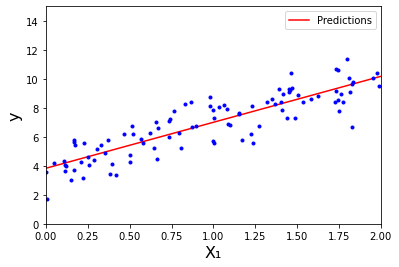

In [5]:
# We can add the model's predictions to our previous plot

pred, = plt.plot(X_new, y_predict, "r-")
pred.set_label("Predictions")
plt.legend()
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

So we now know how to train a linear regression model "manually". Performing it using Scikit-Learn is simpler:

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
print("\N{Greek Small Letter Theta}\N{SUBSCRIPT ZERO}, \N{Greek Small Letter Theta}\N{SUBSCRIPT ONE} =", lin_reg.intercept_, lin_reg.coef_)
print("y predictions:")
lin_reg.predict(X_new)

θ₀, θ₁ = [3.8324178] [[3.16940179]]
y predictions:


array([[ 3.8324178 ],
       [10.17122139]])

The Linear Regression class is based on the scipy.linalg.lstsq() ("least squares") function. 

lstsq(A, b) computes the vector x which minimizes the squared Euclidean distance between A*x and b and returns it, together with the sums of residuals for each column (useful for figuring out if a linear model is appropriate), the rank & "singular values" of A.

We can also call it directly if we're feeling pretty low-level:

In [7]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
print("Model:")
print(theta_best_svd, "\n")
print("Residuals:")
print(residuals, "\n")
print("Rank:")
print(rank, "\n")
print("Singular values:")
print(s, "\n")

Model:
[[3.8324178 ]
 [3.16940179]] 

Residuals:
[102.35400326] 

Rank:
2 

Singular values:
[14.56160696  3.99418412] 



The function computes $\hat{\theta}=X^+y$, where $X^+$ is the *pseudoinverse* (or more precisely, the Moore-Penrose inverse) of X...

which we can also compute directly by using np.linalg.pinv() if we are feeling even more low-level:

In [8]:
np.linalg.pinv(X_b).dot(y)

array([[3.8324178 ],
       [3.16940179]])

Indeed, we can get EVEN DEEPER by using Singular Value Decomposition (see np.linalg.svd()) to find the pseudoinverse, but that is a topic for another day. 

A more pressing thing to think about is that the "Normal equation" method we've been looking at scales pretty poorly with the number of dimensions of our data - computing the pseudoinverse of large matrices is pretty expensive.


Instead, we can learn how to use Batch Gradient Descent to train a linear classifier - on each step of the gradient descent, we use our entire dataset to readjust our parameters.

On each step, the gradient vector of the cost function is $$\frac{2}{m}X^T(X\theta - y)$$, consisting of $$\frac{2}{m} \sum_{i=1}^m(\theta^Tx^{(i)}-y^{(i)})x_j^{(i)}$$ w. respect to each component $\theta_j$.
The gradient vector points "up-hill" on the curve of the cost function, so we just take a step in the opposite direction.

In [9]:
# This is a quick implementation of the Batch Gradient Descent algorithm

eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients # Take a step in the opposite direction of where the gradient vector points
    
theta

array([[3.8324178 ],
       [3.16940179]])

In [10]:
# Let's write a function that plots the predictions after each of the first steps of the process for a given learning rate eta

def plot_early_descent(eta, num_steps=10):

    plt.figure()
    plt.plot(X, y, "b.")
    plt.axis([0, 2, 0, 15])
    plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
    plt.ylabel("y", fontsize=16)

    theta = np.random.randn(2,1) 
    for _ in range(num_steps):
    
        X_new = np.array([[0], [2]])
        X_new_b = np.c_[np.ones((2, 1)), X_new]
        y_predict = X_new_b.dot(theta)
        plt.plot(X_new, y_predict, "r-", alpha=0.42)
    
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients 

    plt.show()

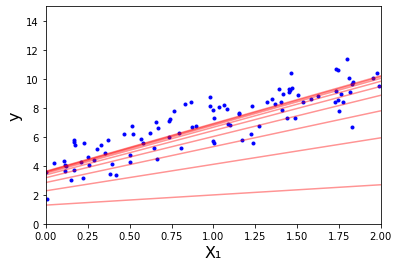

In [11]:
# With a learning rate of 0.1, our predictions should converge rapidly

plot_early_descent(0.1)

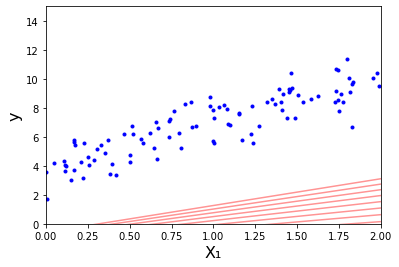

In [12]:
# But if we choose a learning rate that's too low, converging will take much longer

plot_early_descent(0.01)

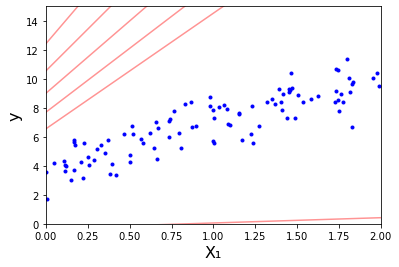

In [13]:
# If we take a learning rate that's too large on the other hand, our algorithm will jump past the optimum again and again, actually making our model continuously worse

plot_early_descent(0.5)

But with a suitable learning rate, Batch Gradient Descent will eventually take us to the optimal solution - sounds pretty good! However, since we use the entirety of the training data on each step, this method becomes very slow if our training set becomes too large. 

At the opposite extreme, Stochastic Gradient Descent picks a random instance at each step and computes the gradients based only on that single instance. Obviously, that makes the algorithm very fast! However, improvement at each step ultimately comes down to chance and our solution will never converge. This has the upside that this method has a better chance of escaping local, non-optimal minima. However, we usually want our algorithm to settle down eventually. To this end, we can implement a learning schedule that makes the learning rate decrease over time. Once the learning rate is close to 0, we have reached a stable solution - which may or may not be optimal, but which will probably be good if we choose our hyperparameters sensibly.

In [14]:
# We choose our max. number of iterations, as well as defining hyperparameters for our learning schedule and the according function, which returns the current learning rate at each step of the Stochastic Gradient Descent algorithm

n_epochs = 50  # number of steps until the algorithm stops
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

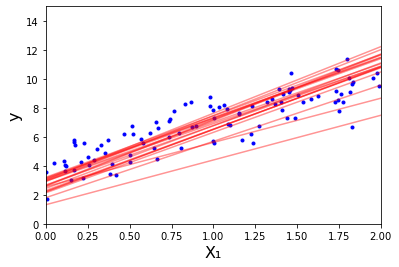

Theta:
 [[3.76011158]
 [3.19517804]]


In [15]:
# We then let the SGD algorithm run, plotting the model on the first 20 steps 

plt.figure()
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        
        if (epoch * m + i < 20):
            X_new = np.array([[0], [2]])
            X_new_b = np.c_[np.ones((2, 1)), X_new]
            y_predict = X_new_b.dot(theta)
            plt.plot(X_new, y_predict, "r-", alpha=0.42)
    
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1] # this looks weird, but we want xi to look like [[1 a]] for xi.T to look like [[1] [a]], instead of [1 a], for the formula to work
        yi = y[random_index]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        
plt.show()
print("Theta:\n", theta)

Our solution isn't quite the optimal one, but very close. We've only passed through our training set 50(=n_epochs) times, as opposed to 1000 times in our Batch Gradient Descent example.

In [16]:
# We can also just use Scikit-Learn to perform SGD for us

from sklearn.linear_model import SGDRegressor

# The following code runs for 1000 epochs or until the loss during one epoch drops by less than 0.001; it starts with a learning rate of 0.1
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
# We use the ravel() function because sgd_reg expects a 1d array, whereas our default y is a column vector.
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([3.78931161]), array([3.145228]))

Again, this is not ideal (despite passing through our training set (up to) 1000 times), but it's very close.

But what if our dataset is nonlinear? Surely, a linear won't work in that case? 


Haha, you thought! One simple way of making it work is to add powers of each feature as new features, then train a linear model on this extended set of features. This is called "Polynomial Regression".

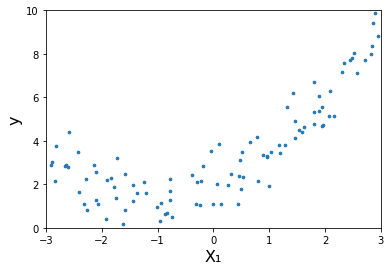

In [17]:
# We generate some nonlinear data, based on a simple quadratic equation.

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.figure()
plt.scatter(X, y, s=7)
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.axis([-3, 3, 0, 10])
plt.show()

A straight line will never fit this data. But we can use Scikit-Learn's PolynomialFeatures class to transform our dataset.

In [18]:
# We add the square of each feature in the training set (in this case just 1: X) as a new feature 

from sklearn.preprocessing import PolynomialFeatures 

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print("X[0]:\t\t", X[0])
print("X_poly[0]:\t", X_poly[0])

X[0]:		 [-2.26705786]
X_poly[0]:	 [-2.26705786  5.13955133]


X_poly now contains the original feature of X & its square. 

In [19]:
# Now we can fit a LinearRegression model to this extended training data.

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.93812205]), array([[1.00242914, 0.48426481]]))

Nice. The model estimates $\hat{y}=0.5x_1^2+x_1+1.95$, when the original function was $\hat{y}=0.5x_1^2+x_1+2$, before adding the Gaussian noise.

Note: When we have multiple features, Polynomial Regression is even capable of finding nonlinear relationships between them, since, given features a and b, PolynomialFeatures(degree=3) would not only add $a^2, a^3, b^2, b^3$, but also $ab, a^2b, ab^2$.

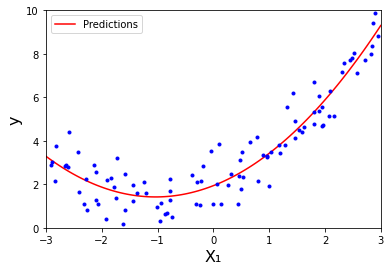

In [20]:
# Let's plot the quadratic model we were able to find via Polynomial Regression

X_coords = np.linspace(-3, 3, 100)
y_predict = lin_reg.coef_[0][1]*X_coords**2 + lin_reg.coef_[0][0]*X_coords + lin_reg.intercept_ 

pred, = plt.plot(X_coords, y_predict, "r-")
pred.set_label("Predictions")
plt.legend()
plt.plot(X, y, "b.")
plt.axis([-3, 3, 0, 10])
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

That does look pretty spot-on!

Attempting to find a more complex (higher-dimension) polynomial model would make us end up overfitting the data and make our model perform much worse on future testing instances. 
A linear model couldn't perform well because we would be underfitting. But how do we tell if a model is over- or underfitting?

One way is using Cross-validation. If the model does very well on the training-, but poorly on the validation set, it's overfitting. If it does poorly on both, it's underfitting. 

Another way is to look at learning curves: Something we'll explore now. 

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    # We split our data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    # After each step of the learning process, we measure the model's average error on the validation set & on the training set
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    
    # After the training process is done, we plot the data we have collected, enabling us to compare the progress our model made on "known" and "unknown" data
    trn, = plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    vltn, = plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    trn.set_label("train")
    vltn.set_label("val")
    plt.legend()
    plt.axis([0, 80, 0, 3])
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")

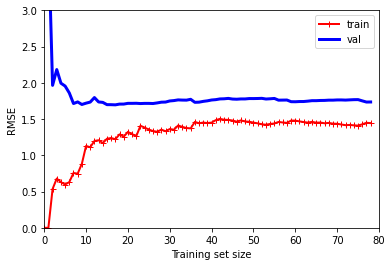

In [37]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

This model is underfitting. 
The training error curve starts at 0, since it can fit one or two instances perfectly. But since the data is noisy and not linear at all, the average error ramps up quickly until it reaches a plateau. 
As the model learns, the valuation error slowly goes down. But it also reaches a plateau, very close to the training error.

These features ar typical for a model that's underfitting: Both curves reach a plateau; they are close and fairly high. 

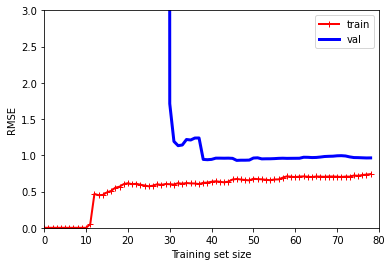

In [23]:
# We can compare the previous result to the learning curve of our Polynomial Regression model

from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)

There are two important differences between this result and the previous one:

- The average error is much lower for both curves
- There is a gap between the curves, which is the hallmark of an overfitting model. (However, the curves would continue to get closer if we had a much larger training set)

In general, we can reduce overfitting by reducing the degrees of freedom our model has - E.g. for a polynomial model this usually means reducing the number of polynomial degrees.

For a linear model, regularization typically involves constraining the weight of the model. Ridge Regression, Lasso Regression and Elastic Net are 3 ways of doing so, which we will now explore. 

#### **Ridge Regression**

Ridge Regression is a regularized version of linear regression; we add a *regularization term* equal to $\alpha\sum_{i=1}^n\theta_i^2$ to the cost function.
This forces our model to keep the weights as small as possible, while still fitting the data.
The larger the hyperparameter $\alpha$ is, the more we regularize the model.
The Ridge Regression cost function is the following:
$$J(\theta)=MSE(\theta) + \alpha\frac{1}{2}\sum_{i=1}^n\theta_i^2$$
Importantly, the sum starts at i=1, meaning that the bias term is not regularized.
For Gradient Descent, we would simply add $\alpha w$ to the MSE gradient vector.

Note: Of course we don't want to add this malus during testing.

Note: It is important that we scale the data before performing Ridge Regression. This is true for most regularized models.

Conveniently, the function above has the closed-form minimum $$\hat{\theta}=(X^TX+\alpha A)^{-1} X^Ty$$,
where A is the (n+1)x(n+1) identity matrix, except with a 0 in the top-left cell, corresponding to the bias term.

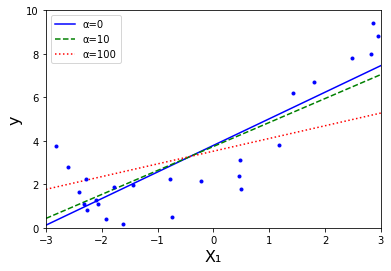

In [24]:
# We can perform Ridge Regression with Scikit-Learn using a closed-form solution 

from sklearn.linear_model import Ridge

# We reduce the size of the dataset to see the effect of Ridge Regression more clearly
X_sample = X[:25]
y_sample=y[:25]

ridge_reg_zero = Ridge(alpha=0, solver="cholesky")
ridge_reg_zero.fit(X_sample,y_sample)

ridge_reg_ten = Ridge(alpha=10, solver="cholesky")
ridge_reg_ten.fit(X_sample,y_sample)

ridge_reg_hun = Ridge(alpha=100, solver="cholesky")
ridge_reg_hun.fit(X_sample,y_sample)

X_coords = np.linspace(-3,3,100)
X_coords = [[x] for x in X_coords]
zero_predict = ridge_reg_zero.predict(X_coords)
ten_predict = ridge_reg_ten.predict(X_coords)
hun_predict = ridge_reg_hun.predict(X_coords)

pred_0, = plt.plot(X_coords, zero_predict, "b-")
pred_0.set_label("\N{GREEK SMALL LETTER ALPHA}=0")
pred_10, = plt.plot(X_coords, ten_predict, "g--")
pred_10.set_label("\N{GREEK SMALL LETTER ALPHA}=10")
pred_100, = plt.plot(X_coords, hun_predict, "r:")
pred_100.set_label("\N{GREEK SMALL LETTER ALPHA}=100")
plt.legend()
plt.plot(X_sample, y_sample, "b.")
plt.axis([-3, 3, 0, 10])
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

Note that increasing $\alpha$ leads to flatter predictions.

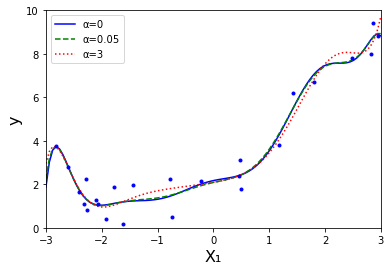

In [25]:
# For demonstration purposes, we can do the same with a polynomial model of degree 10. (We can't forget to scale the attributes!)

from sklearn.preprocessing import StandardScaler

poly_features = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly_features.fit_transform(X_sample)

std_scaler = StandardScaler()
std_scaler.fit_transform(X_poly)

ridge_reg_zero = Ridge(alpha=0, solver="cholesky")
ridge_reg_zero.fit(X_poly,y_sample)

ridge_reg_tiny = Ridge(alpha=0.05, solver="cholesky")
ridge_reg_tiny.fit(X_poly,y_sample)

ridge_reg_one = Ridge(alpha=3, solver="cholesky")
ridge_reg_one.fit(X_poly,y_sample)

X_coords = np.linspace(-3,3,100)
X_coords = [[x] for x in X_coords]
X_coords_poly = poly_features.fit_transform(X_coords)
zero_predict = ridge_reg_zero.predict(X_coords_poly)
tiny_predict = ridge_reg_tiny.predict(X_coords_poly)
hun_predict = ridge_reg_one.predict(X_coords_poly)

pred_0, = plt.plot(X_coords, zero_predict, "b-")
pred_0.set_label("\N{GREEK SMALL LETTER ALPHA}=0")
pred_0_05, = plt.plot(X_coords, tiny_predict, "g--")
pred_0_05.set_label("\N{GREEK SMALL LETTER ALPHA}=0.05")
pred_3, = plt.plot(X_coords, hun_predict, "r:")
pred_3.set_label("\N{GREEK SMALL LETTER ALPHA}=3")
plt.legend()
plt.plot(X_sample, y_sample, "b.")
plt.axis([-3, 3, 0, 10])
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

With polynomial models of such a high degree (which obviously have the tendency to overfit), we can clearly see the impact Ridge Regression can make to come up with a more reasonable model.

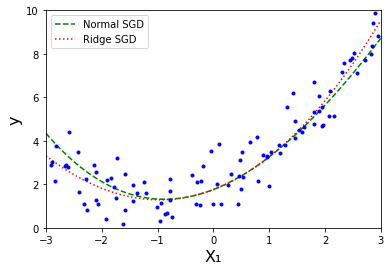

In [26]:
# We can also apply Ridge Regression when using Stochastic Gradient Descent - we assume a polynomial model of degree 3

poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X)

# For purposes of comparison, we also train a normal SGD estimator 
sgd_reg_normal = SGDRegressor()
sgd_reg_normal.fit(X_poly, y.ravel())

# Setting the penalty hyperparameter to "l2" indicates that we want to add a regularization term to the cost function equal to half the length of the weight vector: This is simply Ridge Regression with alpha=1
sgd_reg_ridge = SGDRegressor(penalty="l2")
sgd_reg_ridge.fit(X_poly, y.ravel())

X_coords_poly = poly_features.fit_transform(X_coords)

normal_predict = sgd_reg_normal.predict(X_coords_poly)
ridge_predict = sgd_reg_ridge.predict(X_coords_poly)

pred_normal, = plt.plot(X_coords, normal_predict, "g--")
pred_normal.set_label("Normal SGD")
pred_ridge, = plt.plot(X_coords, ridge_predict, "r:")
pred_ridge.set_label("Ridge SGD")
plt.legend()
plt.plot(X, y, "b.", alpha = 1)
plt.axis([-3, 3, 0, 10])
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

In such a relatively easy example, the effect of Ridge Regression on Stochastic Gradient Descent is barely noticeable - in more complex cases however, it can make a real distance, and now we've seen how to apply it.

#### **Lasso Regression**

Least Absolute Shrinkage and Selection Operator (*LASSO*) Regression is another regularized version of Ridge Regression.

Its cost function looks like

$$ J(\theta)=MSE(\theta)+\alpha\sum_{i=1}^n|\theta_i|$$, so it also adds a regularization term to the MSE function, but it uses the $l_1$ norm instead of half the square of the $l_2$ norm. 

<ipython-input-27-67e6931e3ae7>:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_0.fit(X_sample, y_sample)
C:\Users\larsw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\larsw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.847063903012046, tolerance: 0.019067832030056873
  model = cd_fast.enet_coordinate_descent(


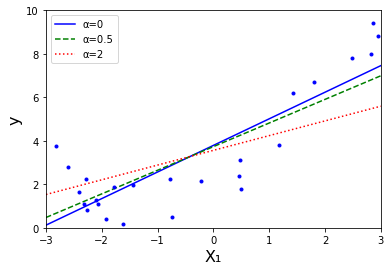

In [27]:
from sklearn.linear_model import Lasso

lasso_0 = Lasso(alpha=0)
lasso_0.fit(X_sample, y_sample)
lasso_0_pred = lasso_0.predict(X_coords)

lasso_0_1 = Lasso(alpha=0.5)
lasso_0_1.fit(X_sample, y_sample)
lasso_0_1_pred = lasso_0_1.predict(X_coords)

lasso_1 = Lasso(alpha=2)
lasso_1.fit(X_sample, y_sample)
lasso_1_pred = lasso_1.predict(X_coords)

pred_0, = plt.plot(X_coords, lasso_0_pred, "b-")
pred_0.set_label("\N{GREEK SMALL LETTER ALPHA}=0")
pred_0_1, = plt.plot(X_coords, lasso_0_1_pred, "g--")
pred_0_1.set_label("\N{GREEK SMALL LETTER ALPHA}=0.5")
pred_1, = plt.plot(X_coords, lasso_1_pred, "r:")
pred_1.set_label("\N{GREEK SMALL LETTER ALPHA}=2")
plt.legend()
plt.plot(X_sample, y_sample, "b.")
plt.axis([-3, 3, 0, 10])
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

We observe the expected behavior: Using a larger alpha value flattens the curve by quite a bit.

Now let's try the same when assuming a polynomial model of, say, degree 10 (as opposed to the actual degree of 2).

<ipython-input-28-a0d52ea49530>:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_0.fit(X_poly, y_sample)
C:\Users\larsw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\larsw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.452726830595928, tolerance: 0.019067832030056873
  model = cd_fast.enet_coordinate_descent(
C:\Users\larsw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.989294160543228, tolerance: 0.019067832030056873
  model = cd_f

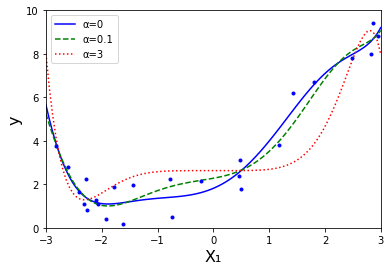

In [28]:
poly_features = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly_features.fit_transform(X_sample)

std_scaler = StandardScaler()
std_scaler.fit_transform(X_poly)

X_coords_poly = poly_features.fit_transform(X_coords)

lasso_0 = Lasso(alpha=0)
lasso_0.fit(X_poly, y_sample)
lasso_0_pred = lasso_0.predict(X_coords_poly)

lasso_0_1 = Lasso(alpha=0.1)
lasso_0_1.fit(X_poly, y_sample)
lasso_0_1_pred = lasso_0_1.predict(X_coords_poly)

lasso_3 = Lasso(alpha=3)
lasso_3.fit(X_poly, y_sample)
lasso_3_pred = lasso_3.predict(X_coords_poly)

pred_0, = plt.plot(X_coords, lasso_0_pred, "b-")
pred_0.set_label("\N{GREEK SMALL LETTER ALPHA}=0")
pred_0_1, = plt.plot(X_coords, lasso_0_1_pred, "g--")
pred_0_1.set_label("\N{GREEK SMALL LETTER ALPHA}=0.1")
pred_3, = plt.plot(X_coords, lasso_3_pred, "r:")
pred_3.set_label("\N{GREEK SMALL LETTER ALPHA}=3")
plt.legend()
plt.plot(X_sample, y_sample, "b.")
plt.axis([-3, 3, 0, 10])
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

One main characteristic of Lasso Regression is that it tends to eliminate the weights of the least important features.
That is because the $l_1$ norm is used - from an arbitrary point, the $l_1$ distance to the origin increases fastest if you decrease the non-zero values in all dimensions by an equal amount, leading you to "hit" some axes sooner than others. Compare this to Euclidean distance (the $l_2$ norm), where the shortest path to the origin involves decreasing the values in those dimensions the most, which have values that are furthest from 0. 

Note: The Lasso cost function is not differentiable at $\theta_i=0$ (for i=1,2,...,n) but Gradient Descent still works fine if you use a subgradient vector **g** iinstead when any $\theta_i=0$. We can think of a subgradient vector at a nondifferentiable point as an intermediate vector between the gradient vectors around that point.

When we want a middle ground between Ridge Regression and Lasso Regression, the Elastic Net regularization technique is the way to go. 
It's just a simple mix of the 2, where hyperparameter r controls the mix ratio. When r = 0, Elastic Net = Ridge Regression. When r = 1, Elastic Net = Lasso Regression.
$$J(\theta) = MSE(\theta) + r\alpha\sum_{i=1}^n|\theta_i|+\frac{1-r}{2}\alpha\sum_{i=1}^n\theta_i^2$$

<ipython-input-29-95340223181b>:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  elastic_net_0.fit(X_poly, y_sample)
C:\Users\larsw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\larsw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.452726830595928, tolerance: 0.019067832030056873
  model = cd_fast.enet_coordinate_descent(
C:\Users\larsw\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.85513740354796, tolerance: 0.019067832030056873
  model = 

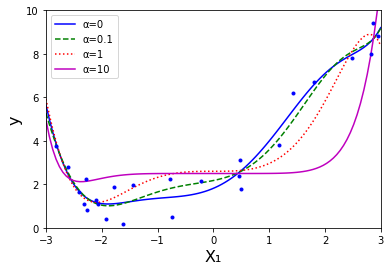

In [29]:
# Using the Elastic Net via Scikit-Learn is no harder than using Ridge or Lasso Regression

from sklearn.linear_model import ElasticNet

elastic_net_0 = ElasticNet(alpha=0, l1_ratio=0.5)
elastic_net_0.fit(X_poly, y_sample)
net_0_pred = elastic_net_0.predict(X_coords_poly)

elastic_net_0_1 = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net_0_1.fit(X_poly, y_sample)
net_0_1_pred = elastic_net_0_1.predict(X_coords_poly)

elastic_net_1 = ElasticNet(alpha=1, l1_ratio=0.5)
elastic_net_1.fit(X_poly, y_sample)
net_1_pred = elastic_net_1.predict(X_coords_poly)

elastic_net_100 = ElasticNet(alpha=100, l1_ratio=0.5)
elastic_net_100.fit(X_poly, y_sample)
net_100_pred = elastic_net_100.predict(X_coords_poly)

pred_0, = plt.plot(X_coords, net_0_pred, "b-")
pred_0.set_label("\N{GREEK SMALL LETTER ALPHA}=0")
pred_0_1, = plt.plot(X_coords, net_0_1_pred, "g--")
pred_0_1.set_label("\N{GREEK SMALL LETTER ALPHA}=0.1")
pred_1, = plt.plot(X_coords, net_1_pred, "r:")
pred_1.set_label("\N{GREEK SMALL LETTER ALPHA}=1")
pred_100, = plt.plot(X_coords, net_100_pred, "m-")
pred_100.set_label("\N{GREEK SMALL LETTER ALPHA}=10")
plt.legend()
plt.plot(X_sample, y_sample, "b.")
plt.axis([-3, 3, 0, 10])
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

We can clearly see the influence the Lasso Regression part has on the model.

But there is another effective way to regularize iterative learning algorithms: Early Stopping.
The idea is pretty straight-forward. Evaluate your model on the validation set on each step. And when your cost function has reached a minimum, you stop and roll with the current "best model".
For algorithms that tend to "jump around" (e.g. Stochastic and Mini-Batch Gradient Descent) we can just remember the best model we've found so far and go back to it as our final version once we're confident the model won't improve any further.

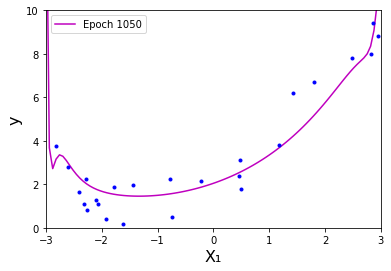

In [56]:
from copy import deepcopy
import warnings

# prepare the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)
X_coords_poly_scaled = poly_scaler.transform(X_coords)

# We ignore warnings about the model not having converged yet
warnings.filterwarnings(action='ignore')

# Note the warm_start hyperparameter: Whenever the fit() method is called, it continues where it left off, instead of starting over
sgd_reg = SGDRegressor(max_iter=1, tol=np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(10000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel())
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)
        
pred, = plt.plot(X_coords, best_model.predict(X_coords_poly_scaled), "m-")
pred.set_label("Epoch " + str(best_epoch))
plt.legend()
plt.plot(X_sample, y_sample, "b.")
plt.axis([-3, 3, 0, 10])
plt.xlabel("X\N{SUBSCRIPT ONE}", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

# Reactivate warnings for future cells
warnings.filterwarnings(action='ignore')

That does look quite relaxed for a polynomial of degree 90

#### Logistic Regression

Logistic Regression is often used to estimate the probability that an instance belongs to a particular class. 
Like a Linear Regression model, it computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression model does, it outputs the *logistic* of this result. 

$$\hat{p}=h_\theta(x)=\sigma(x^T\theta)$$, where $\sigma(t)$ is the logistic function $\frac{1}{1+exp(-t)}$

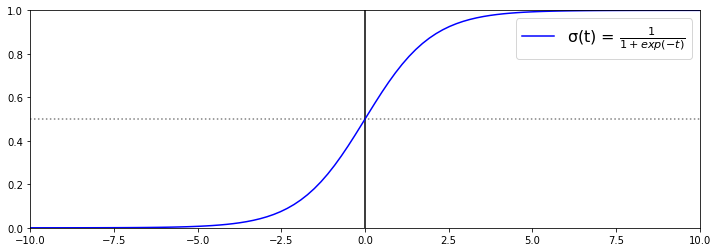

In [91]:
import math

log_coords = np.linspace(-10, 10, 100)

y = [None] * len(log_coords)
for i in range(len(y)):
    y[i] = 1 / (1 + math.exp(-log_coords[i]))
    
plt.figure(figsize=(12,4))
    
# plot y-axis
plt.plot([0, 0], [0, 1], "k-")

# plot sigma function
pred, = plt.plot(log_coords, y, "b-")
pred.set_label("\N{GREEK SMALL LETTER SIGMA}(t) = " + r"$\frac{1}{1+exp(-t)}$")
plt.legend(prop={'size': 16})

# plot horizontal line
plt.plot(log_coords, [0.5]*len(log_coords), "k:", alpha=0.5)

plt.axis([-10, 10, 0, 1])
plt.show()

A Logistic Regression model that is used as a binary classifier, would assign value 1 to prediction $\hat{y}$ if $\hat{p}\geq 0.5$.

But how do we train a Logistic Regression model?

The cost function of a single training instance is given by 
$$-log(\hat{p}), y=1$$
and
$$-log(1-\hat{p}), y=0$$.

Note that -log(t) grows very large when t approaches 0, so the cost will be large if the model estimates a probability close to 0 for a positive instance.
Likewise, -log(t) is close to 0 when t is close to 1. 

The cost function over the whole training set is then $$J(\theta)=-\frac{1}{m}\sum_{i=1}^m[y^{(i)}log(\hat{p}^{(i)}+(1-y^{(i)})log(1-\hat{p}^{(i)})]$$, which sadly does not have a known closed-form solution. However, it is convex so optimization algorithms are guaranteed to find the global minimum (with suitable hyperparameters). The partial derivatives of the cost function with respect to $\theta_j$ are given by 
$$\frac{\delta}{\delta\theta_j}J(\theta)=\frac{1}{m}\sum_{i=1}^m(\sigma(\theta^Tx^{(i)})-y^{(i)})x_j^{(i)}$$

We can explore training a Logistic Regression classifier using the famous Iris dataset.

In [96]:
# First, we load the data

from sklearn import datasets

iris = datasets.load_iris()
print("Keys:", list(iris.keys()))
X = iris["data"][:, 3:] # we choose X to be the petal width
# Based on the petal width, we estimate if a flower in our dataset belongs to the "Iris virginica" species
y = (iris["target"] == 2).astype(np.int) # 1 if Iris virginica, else 0 

Keys: ['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename']


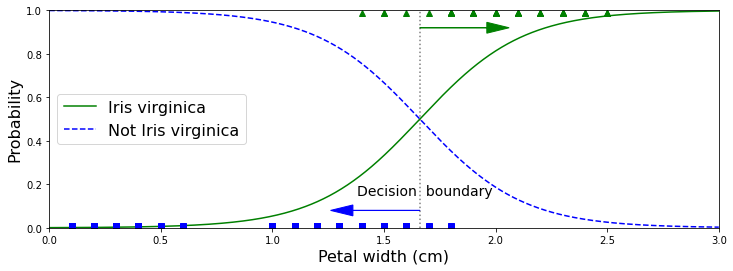

In [141]:
# Now let's train a Logistic Regression model

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

plt.figure(figsize=(12,4))

# We can look at the models estimatd probabilities for flowers with petal widths varying from 0 to 3 cm 
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

# X value at which the lines cross
decision_boundary = X_new[np.argmax(y_proba[:, 1] >= y_proba[:, 0])]
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", alpha=0.5)

aye, = plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
aye.set_label("Iris virginica")
nae, = plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")
nae.set_label("Not Iris virginica")

# The blue squares represent the petal width of each flower of class "Not Iris virginica"
plt.plot(X[y==0], y[y==0]+0.01, "bs")
# The green triangles represent the petal width of each flower of class "Iris virginica"
plt.plot(X[y==1], y[y==1]-0.01, "g^")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')

plt.xlabel("Petal width (cm)", fontsize=16)
plt.ylabel("Probability", fontsize=16)
plt.legend(loc="center left", prop={'size': 16})
plt.axis([0, 3, 0, 1])
plt.show()

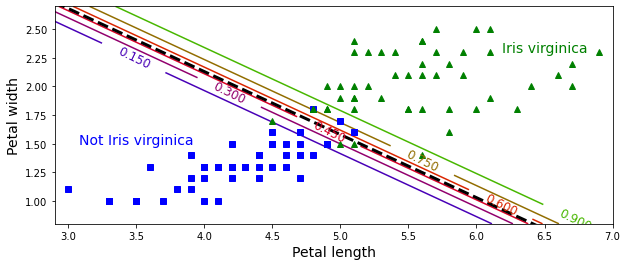

In [185]:
# We can also train a Logistic Regression models for data with more than one feature

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

# A very high value of C denotes a very small regularization strength (see note below).
log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
    np.linspace(2.9, 7, 410).reshape(-1, 1),
    np.linspace(0.8, 2.7, 190).reshape(-1, 1))
# We stack the 2 coordinate arrays into a 2-D array
X_new = np.column_stack([x0.ravel(), x1.ravel()])

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs") # Slightly cleaner: X[(y==0), 0]
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

# Assign to each new coordinate the probability of the according input to have label 1 (Iris virginica)
probas = y_proba[:, 1].reshape(x0.shape)

# Draw colourful contours for the 15%, 30%, 45%, 60%, 75% and 90% confidence boundaries
contour = plt.contour(x0, x1, probas, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)

# The decision boundary, given by {x | theta_0 + theta_1 * x_1 + theta_2 * x_2 = 0}, is a straight line, which we can draw in our x_1 / x_2 - coordinate system
x_limits = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * x_limits + log_reg.intercept_[0]) / log_reg.coef_[0][1]
plt.plot(x_limits, boundary, "k--", linewidth=3)

# We add text describing the two classes
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])

plt.show()

Note: Like the other linear models, we can add regularize Logistic Regression models by using $l_1$ or $l_2$ penalties. Scikit-Learn actually adds a $l_2$ penalty by default.

Note: The hyperparameter controlling the regularization strength is not $\alpha$ though, it's its inverse, denoted as C.